In [1]:
# hidden_size = 700
# 'mape': 0.08602340939134848
# hidden_size = 800
# 'mape': 0.06639103686177132
# hidden_size = 900
# 'mape': 0.05098046978835269
# hidden_size = 1000
# 'mape': 0.08374328898166881


In [2]:
import numpy as np
import pandas as pd
import pickle

from tqdm import tqdm
import math, random

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import date
from datetime import timedelta
import gc
import openpyxl

from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error

import paddle
import paddle.nn as nn
from paddle.optimizer import AdamW
from paddle.optimizer.lr import LinearWarmup

from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

SEED = 2022
random.seed(SEED)
np.random.seed(SEED)
paddle.seed(SEED)

In [3]:
# 加载数据
# 仪表能耗
file_name = './work/AI_data/df_meter_daily.pkl'
with open(file_name, 'rb') as f:
    df_meter_daily = pickle.load(f)

# 日期
file_name = './work/AI_data/df_dates.pkl'
with open(file_name, 'rb') as f:
    df_dates = pickle.load(f)

# 每日天气
file_name = './work/AI_data/weather_daily.pkl'
with open(file_name, 'rb') as f:
    weather_daily = pickle.load(f)

# 每小时天气
file_name = './work/AI_data/weather_hour.pkl'
with open(file_name, 'rb') as f:
    weather_hour = pickle.load(f)

# 每日+每小时天气
file_name = './work/AI_data/df_weather_dt.pkl'
with open(file_name, 'rb') as f:
    df_weather_dt = pickle.load(f)

# 每日客流
file_name = './work/AI_data/df_area_custflow.pkl'
with open(file_name, 'rb') as f:
    df_area_custflow = pickle.load(f)

df_meter_daily.shape, df_dates.shape, weather_daily.shape, weather_hour.shape, df_weather_dt.shape,\
df_area_custflow.shape

((625, 243), (273, 88), (301, 243), (7224, 243), (7525, 243), (824, 243))

In [4]:
### 过滤仪表数据

In [5]:
# df_meter_daily

In [6]:
meter_index = df_meter_daily.index
df_meter_daily.index = df_meter_daily.index.droplevel(level=[1,2,3,4,5])

In [7]:
no_need_pred_meter = np.all(df_meter_daily.iloc[:, -14::] <= -0.0001, axis=1)

df_noneed = pd.DataFrame(np.zeros([no_need_pred_meter.sum(), 7]),
             index=df_meter_daily[no_need_pred_meter].index)

# df_meter_daily[no_need_pred_meter].to_csv("./test.csv")

df_meter_daily = df_meter_daily[np.logical_not(no_need_pred_meter)]

In [8]:
meters = list(df_meter_daily.index)

In [9]:
idxs = []
for ids in df_area_custflow.index:
    idxs.append(ids[0] + '_' + str(ids[1]))
df_area_custflow.index = idxs

In [10]:
df_meter_daily = df_meter_daily.T
# df_dates = df_dates.T
df_weather_dt = df_weather_dt.T
# df_area_custflow = df_area_custflow.T

In [11]:
dates_cols = list(df_dates.columns)
weather_dt_cols = list(df_weather_dt.columns)
# custflow_cols = list(df_area_custflow.index)

In [12]:
meter_max = df_meter_daily.max() + 1
df_meter_daily = df_meter_daily / meter_max

In [13]:
# 日期、天气、客流数据归一化
scaler_date = MinMaxScaler()
df_dates.iloc[:,:] = scaler_date.fit_transform(df_dates)

scaler_weather = MinMaxScaler()
df_weather_dt.iloc[:,:] = scaler_weather.fit_transform(df_weather_dt)

In [14]:
# 拼装数据
original_data = df_meter_daily.join(df_dates, how='left').join(df_weather_dt, how='left')#.join(df_area_custflow, how='left')
cols_to_transform = dates_cols + weather_dt_cols# + custflow_cols

In [15]:
# ARIMA模型评价
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))
    me = np.mean(forecast - actual)
    mae = np.mean(np.abs(forecast - actual))
    mpe = np.mean((forecast - actual)/actual)
    # rmse = np.mean((forecast - actual)**2)**0.5    # RMSE
    rmse_1 = np.sqrt(sum((forecast - actual) ** 2) / actual.size)
    corr = np.corrcoef(forecast, actual)[0, 1]
    mins = np.amin(np.hstack([forecast[:, None], actual[:, None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:, None], actual[:, None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)
    return ({'mape': mape,
             'me': me,
             'mae': mae,
             'mpe': mpe,
             'rmse': rmse_1,
             'corr': corr,
             'minmax': minmax
             })

In [16]:
# choose a number of time steps
n_steps_in, n_steps_out = 31, 7  # 可以尝试更改

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out, features_out):
	X, y = list(), list()
	seq_len = len(sequences)
	for i in range(seq_len):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the dataset
		if out_end_ix > seq_len:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences.iloc[i:end_ix, :].values, sequences.iloc[end_ix:out_end_ix][meters].values
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)
 

In [17]:
# covert into input/output
X_train, y_train = split_sequences(original_data, n_steps_in, n_steps_out, meters)
print(X_train.shape, y_train.shape)
# summarize the data
# for i in range(len(X)):
# 	print(X[i], y[i])

X_test = original_data.iloc[-n_steps_in:, :].values

(206, 31, 8238) (206, 7, 625)


In [18]:
# df_dates.dtypes

# covert into input/output
# X_train_dates, _ = split_sequences(df_dates, n_steps_in, n_steps_out)
# print(X_train_dates.shape)

In [19]:
X_train = X_train.astype(np.float32)
y_train = y_train.astype(np.float32)
X_test = X_test.astype(np.float32)

In [20]:
n_epochs = 800
hidden_size = 1000 # try to change this parameters 
num_layers = 1
batch_size = 10
input_size = X_train.shape[2]
output_size = len(df_meter_daily.columns)
# n_steps_in = X_train.shape[1]
# n_steps_out = y_train.shape[1]

# BATCH_SIZE = 64
LEARNING_RATE = 0.005
WEIGHT_DECAY = 1e-2
EPSILON = 1e-8

keep_iter = 999999999 # 停止迭代步幅
min_loss = 9999999999 # 最小 loss
best_step = 0 # 最佳迭代次数
submit_csv = 'submit.csv' # 提交文件
best_model = './work/model_saved/best_model3.pdparams' # 最佳模型文件

In [21]:
from paddle.io import BatchSampler, DataLoader, TensorDataset

train_dataset = TensorDataset([paddle.to_tensor(X_train, dtype='float32'), paddle.to_tensor(y_train, dtype='float32')])
data_loader = DataLoader(train_dataset, batch_size=batch_size)

In [22]:
# 搭建模型，重新写
class LSTMNET(nn.Layer):
    def __init__(self, input_size, hidden_size, num_layers, batch_size, output_size, n_steps_in, n_steps_out):
        super(LSTMNET, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.batch_size = batch_size
        self.output_size = output_size
        self.n_steps_in = n_steps_in
        self.n_steps_out = n_steps_out


        # self.embedding_date = paddle.nn.Embedding(num_embeddings=256, embedding_dim=20, sparse=True)
        self.lstm_encoder = nn.LSTM(input_size, hidden_size, num_layers, direction='forward')
        self.sigma1 = nn.Softplus()
        #RepeatVector(n_steps_out)
        self.lstm_decoder = nn.LSTM(hidden_size, hidden_size, num_layers, direction='forward')
        self.sigma2 = nn.Softplus()
        # self.fc = nn.Linear(n_steps_out * hidden_size, n_steps_out * output_size)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, inputs):
        in_size = inputs.shape[0]
        hidden = self.__init__hidden(in_size)

        # print(dates.shape)
        # date_emb = self.embedding_date(dates)
        # print(date_emb.shape)
        # aaa

        _, (hidden, _) = self.lstm_encoder(inputs, hidden)
        hidden = self.sigma1(hidden)
        hidden = paddle.to_tensor(hidden.tolist() * n_steps_out).transpose((1,0,2))
        lstm_out, (_, _) = self.lstm_decoder(hidden)
        lstm_out = self.sigma2(lstm_out)
        # lstm_out = lstm_out.reshape([in_size, -1])
        output = self.fc(lstm_out).clip(0)
        # output = output.reshape([in_size, -1, output_size])

        return output, hidden

    def __init__hidden(self, in_size):
        hidden = (paddle.zeros([self.num_layers, in_size, self.hidden_size], dtype='float32'),
                  paddle.zeros([self.num_layers, in_size, self.hidden_size], dtype='float32'))
        return hidden

In [23]:
'''
# 多步输入多步输出
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(RepeatVector(n_steps_out))
model.add(LSTM(200, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(n_features)))
model.compile(optimizer='adam', loss='mse')
'''
'''
# deepAR
self.lstm = tf.keras.layers.LSTM(lstm_units, return_sequences=True, return_state=True)
        self.dense_mu = tf.keras.layers.Dense(1)
        self.dense_sigma = tf.keras.layers.Dense(1, activation='softplus')
————————————————
版权声明：本文为CSDN博主「虚胖一场」的原创文章，遵循CC 4.0 BY-SA版权协议，转载请附上原文出处链接及本声明。
原文链接：https://blog.csdn.net/weixin_45073190/article/details/104951504
'''

'''
# 原先自己写的网络
        self.bn = nn.BatchNorm1d(n_steps)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
#         self.relu = nn.ReLU(inplace=True)
        self.fc1 = nn.Linear(n_steps * hidden_size, int(focst_steps * output_size * 1.5), bias=True)
        self.fc2 = nn.Linear(int(focst_steps * output_size * 1.5), focst_steps * output_size, bias=True)
'''

'\n# 原先自己写的网络\n        self.bn = nn.BatchNorm1d(n_steps)\n        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)\n#         self.relu = nn.ReLU(inplace=True)\n        self.fc1 = nn.Linear(n_steps * hidden_size, int(focst_steps * output_size * 1.5), bias=True)\n        self.fc2 = nn.Linear(int(focst_steps * output_size * 1.5), focst_steps * output_size, bias=True)\n'

In [24]:
lstm_model = LSTMNET(input_size, hidden_size, num_layers, batch_size, output_size, n_steps_in, n_steps_out)

W0522 16:26:43.899674  8307 device_context.cc:447] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 11.2, Runtime API Version: 10.1
W0522 16:26:43.903194  8307 device_context.cc:465] device: 0, cuDNN Version: 7.6.


In [25]:
criterion = nn.SmoothL1Loss()

no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
        {'params': [p for n, p in lstm_model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': WEIGHT_DECAY},
        {'params': [p for n, p in lstm_model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

scheduler_lr = LinearWarmup(learning_rate = LEARNING_RATE, warmup_steps = 10, start_lr = 0.002, \
                        end_lr = LEARNING_RATE, verbose=False)
optimizer = AdamW(parameters = optimizer_grouped_parameters, learning_rate = scheduler_lr, \
                weight_decay=WEIGHT_DECAY, epsilon=EPSILON)

# optimizer = AdamW(parameters = optimizer_grouped_parameters, learning_rate = LEARNING_RATE, \
#                 weight_decay=WEIGHT_DECAY, epsilon=EPSILON)

lrs = []

lstm_loss = np.empty(n_epochs)
lstm_score = []

In [26]:
import time
import datetime
# 时间格式化
def format_time(elapsed):    
    elapsed_rounded = int(round((elapsed)))    
    return str(datetime.timedelta(seconds=elapsed_rounded))   #返回 hh:mm:ss 形式的时间

In [27]:
# 训练模型
# 记录当前时刻
t0 = time.time()
for epoch in tqdm(range(n_epochs)):
    lstm_model.train()
    epoch_losses = []
    
    for iter_, t in enumerate(data_loader):
        # if t[0].shape[0] != batch_size: continue

#         random_index = random.randint(0, t.shape[-1] - seq_length - 1)
#         train_x = t[:, random_index: random_index+seq_length]
#         train_y = t[:, random_index + 1: random_index + seq_length + 1]

        train_x = t[0]
        train_y = t[1]

        outputs, hidden = lstm_model(train_x)

        optimizer.clear_grad()
        loss = criterion(outputs.reshape([-1]), train_y.reshape([-1]))
        loss.backward()
        optimizer.step()
        
        lrs.append(optimizer.get_lr())
        # scheduler_lr.step()

        epoch_losses.append(loss.item())
        if ((epoch + 1)%200 == 0):
            elapsed = format_time(time.time() - t0)
            print("epoch:{}  iter:{}  loss:{} Elapsed:{}".format(epoch, iter_, loss, elapsed))
            
#         if iter_ == 0:
#             plt.clf();
#             plt.ion()
#             plt.title("Epoch {}, iter {}".format(epoch, iter_))
#             plt.plot(torch.flatten(outputs.detach()),'r-',linewidth=1,label='Output')
#             plt.plot(torch.flatten(train_y),'c-',linewidth=1,label='Label')
#             plt.plot(torch.flatten(train_x),'g-',linewidth=1,label='Input')
#             plt.draw();
#             plt.pause(0.05);
    scheduler_lr.step()
    
    lstm_loss[epoch] = np.mean(epoch_losses)
    
    # evaluate
    lstm_model.eval()
    with paddle.no_grad():
        score = (mean_absolute_error(train_y.reshape([train_y.shape[0], -1]).detach(),
                                    lstm_model(train_x)[0].reshape([train_y.shape[0], -1]).detach()))
        lstm_score.append(score)
        
        # 模型保存
        if score < min_loss:
            min_loss = score
            best_step = epoch
            paddle.save(lstm_model.state_dict(), best_model)
            print('saving best model, mae: %f step: %d' % (score, epoch))

        if (epoch - best_step) > keep_iter:
            break

  0%|          | 1/800 [00:04<1:06:34,  5.00s/it]

saving best model, mae: 0.151886 step: 0


  0%|          | 2/800 [00:09<1:04:42,  4.87s/it]

saving best model, mae: 0.103770 step: 1


  0%|          | 3/800 [00:16<1:14:50,  5.63s/it]

saving best model, mae: 0.095926 step: 2


  0%|          | 4/800 [00:24<1:23:50,  6.32s/it]

saving best model, mae: 0.083585 step: 3


  2%|▏         | 13/800 [00:31<23:49,  1.82s/it] 

saving best model, mae: 0.079355 step: 12


  3%|▎         | 22/800 [00:38<23:03,  1.78s/it]

saving best model, mae: 0.077359 step: 21


  5%|▌         | 43/800 [00:51<29:21,  2.33s/it]

saving best model, mae: 0.076696 step: 42


 25%|██▍       | 199/800 [01:43<03:39,  2.74it/s]

epoch:199  iter:0  loss:Tensor(shape=[1], dtype=float32, place=CUDAPlace(0), stop_gradient=False,
       [0.05651719]) Elapsed:0:01:43
epoch:199  iter:1  loss:Tensor(shape=[1], dtype=float32, place=CUDAPlace(0), stop_gradient=False,
       [0.04713361]) Elapsed:0:01:43
epoch:199  iter:2  loss:Tensor(shape=[1], dtype=float32, place=CUDAPlace(0), stop_gradient=False,
       [0.05123751]) Elapsed:0:01:43
epoch:199  iter:3  loss:Tensor(shape=[1], dtype=float32, place=CUDAPlace(0), stop_gradient=False,
       [0.04281290]) Elapsed:0:01:43
epoch:199  iter:4  loss:Tensor(shape=[1], dtype=float32, place=CUDAPlace(0), stop_gradient=False,
       [0.02764152]) Elapsed:0:01:43
epoch:199  iter:5  loss:Tensor(shape=[1], dtype=float32, place=CUDAPlace(0), stop_gradient=False,
       [0.02251421]) Elapsed:0:01:43
epoch:199  iter:6  loss:Tensor(shape=[1], dtype=float32, place=CUDAPlace(0), stop_gradient=False,
       [0.02027411]) Elapsed:0:01:43
epoch:199  iter:7  loss:Tensor(shape=[1], dtype=float32

 25%|██▌       | 200/800 [01:43<03:35,  2.79it/s]

epoch:199  iter:13  loss:Tensor(shape=[1], dtype=float32, place=CUDAPlace(0), stop_gradient=False,
       [0.02538658]) Elapsed:0:01:44
epoch:199  iter:14  loss:Tensor(shape=[1], dtype=float32, place=CUDAPlace(0), stop_gradient=False,
       [0.02594694]) Elapsed:0:01:44
epoch:199  iter:15  loss:Tensor(shape=[1], dtype=float32, place=CUDAPlace(0), stop_gradient=False,
       [0.02465361]) Elapsed:0:01:44
epoch:199  iter:16  loss:Tensor(shape=[1], dtype=float32, place=CUDAPlace(0), stop_gradient=False,
       [0.02517971]) Elapsed:0:01:44
epoch:199  iter:17  loss:Tensor(shape=[1], dtype=float32, place=CUDAPlace(0), stop_gradient=False,
       [0.02365087]) Elapsed:0:01:44
epoch:199  iter:18  loss:Tensor(shape=[1], dtype=float32, place=CUDAPlace(0), stop_gradient=False,
       [0.02022581]) Elapsed:0:01:44
epoch:199  iter:19  loss:Tensor(shape=[1], dtype=float32, place=CUDAPlace(0), stop_gradient=False,
       [0.02188457]) Elapsed:0:01:44
epoch:199  iter:20  loss:Tensor(shape=[1], dtype

 50%|████▉     | 399/800 [03:22<04:14,  1.57it/s]

epoch:399  iter:0  loss:Tensor(shape=[1], dtype=float32, place=CUDAPlace(0), stop_gradient=False,
       [0.05668154]) Elapsed:0:03:23
epoch:399  iter:1  loss:Tensor(shape=[1], dtype=float32, place=CUDAPlace(0), stop_gradient=False,
       [0.04791278]) Elapsed:0:03:23
epoch:399  iter:2  loss:Tensor(shape=[1], dtype=float32, place=CUDAPlace(0), stop_gradient=False,
       [0.05192569]) Elapsed:0:03:23
epoch:399  iter:3  loss:Tensor(shape=[1], dtype=float32, place=CUDAPlace(0), stop_gradient=False,
       [0.04272480]) Elapsed:0:03:23
epoch:399  iter:4  loss:Tensor(shape=[1], dtype=float32, place=CUDAPlace(0), stop_gradient=False,
       [0.02740207]) Elapsed:0:03:23
epoch:399  iter:5  loss:Tensor(shape=[1], dtype=float32, place=CUDAPlace(0), stop_gradient=False,
       [0.02322366]) Elapsed:0:03:23
epoch:399  iter:6  loss:Tensor(shape=[1], dtype=float32, place=CUDAPlace(0), stop_gradient=False,
       [0.02049771]) Elapsed:0:03:23
epoch:399  iter:7  loss:Tensor(shape=[1], dtype=float32

 50%|█████     | 400/800 [03:23<04:15,  1.56it/s]

epoch:399  iter:14  loss:Tensor(shape=[1], dtype=float32, place=CUDAPlace(0), stop_gradient=False,
       [0.02571301]) Elapsed:0:03:23
epoch:399  iter:15  loss:Tensor(shape=[1], dtype=float32, place=CUDAPlace(0), stop_gradient=False,
       [0.02465568]) Elapsed:0:03:23
epoch:399  iter:16  loss:Tensor(shape=[1], dtype=float32, place=CUDAPlace(0), stop_gradient=False,
       [0.02529913]) Elapsed:0:03:23
epoch:399  iter:17  loss:Tensor(shape=[1], dtype=float32, place=CUDAPlace(0), stop_gradient=False,
       [0.02361023]) Elapsed:0:03:23
epoch:399  iter:18  loss:Tensor(shape=[1], dtype=float32, place=CUDAPlace(0), stop_gradient=False,
       [0.02001101]) Elapsed:0:03:23
epoch:399  iter:19  loss:Tensor(shape=[1], dtype=float32, place=CUDAPlace(0), stop_gradient=False,
       [0.02168211]) Elapsed:0:03:23
epoch:399  iter:20  loss:Tensor(shape=[1], dtype=float32, place=CUDAPlace(0), stop_gradient=False,
       [0.01888816]) Elapsed:0:03:23


 75%|███████▍  | 599/800 [05:31<02:34,  1.30it/s]

epoch:599  iter:0  loss:Tensor(shape=[1], dtype=float32, place=CUDAPlace(0), stop_gradient=False,
       [0.05586620]) Elapsed:0:05:32
epoch:599  iter:1  loss:Tensor(shape=[1], dtype=float32, place=CUDAPlace(0), stop_gradient=False,
       [0.04699975]) Elapsed:0:05:32
epoch:599  iter:2  loss:Tensor(shape=[1], dtype=float32, place=CUDAPlace(0), stop_gradient=False,
       [0.05137838]) Elapsed:0:05:32
epoch:599  iter:3  loss:Tensor(shape=[1], dtype=float32, place=CUDAPlace(0), stop_gradient=False,
       [0.04278839]) Elapsed:0:05:32
epoch:599  iter:4  loss:Tensor(shape=[1], dtype=float32, place=CUDAPlace(0), stop_gradient=False,
       [0.02736672]) Elapsed:0:05:32
epoch:599  iter:5  loss:Tensor(shape=[1], dtype=float32, place=CUDAPlace(0), stop_gradient=False,
       [0.02222956]) Elapsed:0:05:32
epoch:599  iter:6  loss:Tensor(shape=[1], dtype=float32, place=CUDAPlace(0), stop_gradient=False,
       [0.01992715]) Elapsed:0:05:32
epoch:599  iter:7  loss:Tensor(shape=[1], dtype=float32

 75%|███████▌  | 600/800 [05:32<02:46,  1.20it/s]

epoch:599  iter:18  loss:Tensor(shape=[1], dtype=float32, place=CUDAPlace(0), stop_gradient=False,
       [0.01950388]) Elapsed:0:05:33
epoch:599  iter:19  loss:Tensor(shape=[1], dtype=float32, place=CUDAPlace(0), stop_gradient=False,
       [0.02105674]) Elapsed:0:05:33
epoch:599  iter:20  loss:Tensor(shape=[1], dtype=float32, place=CUDAPlace(0), stop_gradient=False,
       [0.01830759]) Elapsed:0:05:33


100%|█████████▉| 799/800 [07:36<00:00,  1.81it/s]

epoch:799  iter:0  loss:Tensor(shape=[1], dtype=float32, place=CUDAPlace(0), stop_gradient=False,
       [0.05652444]) Elapsed:0:07:37
epoch:799  iter:1  loss:Tensor(shape=[1], dtype=float32, place=CUDAPlace(0), stop_gradient=False,
       [0.04754897]) Elapsed:0:07:37
epoch:799  iter:2  loss:Tensor(shape=[1], dtype=float32, place=CUDAPlace(0), stop_gradient=False,
       [0.05187090]) Elapsed:0:07:37
epoch:799  iter:3  loss:Tensor(shape=[1], dtype=float32, place=CUDAPlace(0), stop_gradient=False,
       [0.04286450]) Elapsed:0:07:37
epoch:799  iter:4  loss:Tensor(shape=[1], dtype=float32, place=CUDAPlace(0), stop_gradient=False,
       [0.02794514]) Elapsed:0:07:37
epoch:799  iter:5  loss:Tensor(shape=[1], dtype=float32, place=CUDAPlace(0), stop_gradient=False,
       [0.02312483]) Elapsed:0:07:37
epoch:799  iter:6  loss:Tensor(shape=[1], dtype=float32, place=CUDAPlace(0), stop_gradient=False,
       [0.02050141]) Elapsed:0:07:37
epoch:799  iter:7  loss:Tensor(shape=[1], dtype=float32

100%|██████████| 800/800 [07:37<00:00,  1.75it/s]

epoch:799  iter:16  loss:Tensor(shape=[1], dtype=float32, place=CUDAPlace(0), stop_gradient=False,
       [0.02519475]) Elapsed:0:07:37
epoch:799  iter:17  loss:Tensor(shape=[1], dtype=float32, place=CUDAPlace(0), stop_gradient=False,
       [0.02370583]) Elapsed:0:07:37
epoch:799  iter:18  loss:Tensor(shape=[1], dtype=float32, place=CUDAPlace(0), stop_gradient=False,
       [0.02027061]) Elapsed:0:07:37
epoch:799  iter:19  loss:Tensor(shape=[1], dtype=float32, place=CUDAPlace(0), stop_gradient=False,
       [0.02181414]) Elapsed:0:07:37
epoch:799  iter:20  loss:Tensor(shape=[1], dtype=float32, place=CUDAPlace(0), stop_gradient=False,
       [0.01881140]) Elapsed:0:07:37


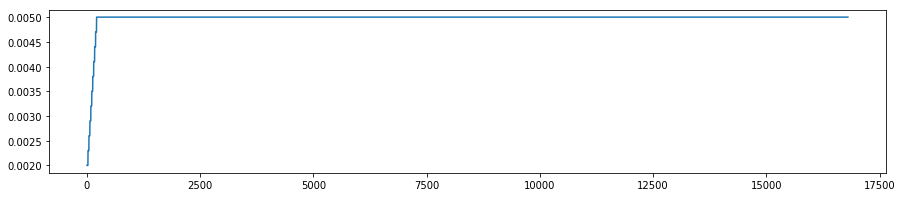

In [28]:
plt.figure(figsize=(15, 3))
plt.plot(lrs)

0.07669628 42


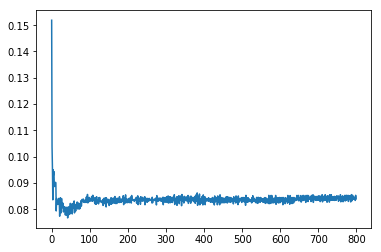

In [29]:
print(np.min(lstm_score), np.argmin(lstm_score))
plt.plot(lstm_score)
#231

0.026658235206490473 15


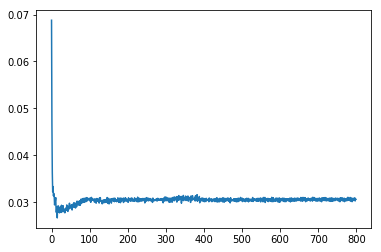

In [30]:
print(lstm_loss.min(), lstm_loss.argmin())
plt.plot(lstm_loss)
#250

In [31]:
#保存训练模型
# file_name = './work/model_saved/光环能耗_LSTM_{}'.format(n_epochs)
# paddle.save(lstm_model, file_name)
# print(file_name+' saved')

In [32]:
# 加载模型
# file_name = './model_saved/光环能耗_LSTM_140.pt'
# lstm_model = torch.load(file_name)

lstm_model.set_state_dict(paddle.load(best_model))

### 进行预测

In [33]:
# 测试数据集
# X_test = torch.from_numpy(X_test).unsqueeze(0)
test_x = paddle.to_tensor(X_test, dtype='float32').unsqueeze(0)

In [34]:
# 预测
lstm_model.eval()
with paddle.no_grad():
    y_pred, _ = lstm_model(test_x)
    # y_pred = y_pred.clip(0)

In [35]:
df_preds = pd.DataFrame(y_pred.numpy().squeeze(0), columns=meters)

In [36]:
df_preds = (df_preds * meter_max).T

### 处理能耗科目

In [37]:
df_energyitem = pd.read_excel('./work/AI_data/1.3 t_research_energyitem.xlsx')
df_energyitem = df_energyitem[['c_order', 'c_logic_id', 'c_name', 'c_parent']]

In [38]:
def get_energyitem_level(item):
    if len(df_energyitem[df_energyitem['c_logic_id'] == item]) == 0:
        return 0
    else:
        p_item = df_energyitem[df_energyitem['c_logic_id'] == item]['c_parent'].values[0]
#         print(item, p_item)
        return 1 + get_energyitem_level(p_item)

In [39]:
def is_leaf(item):
    if len(df_energyitem[df_energyitem['c_parent'] == item]) == 0:
        return True
    else:
        return False

In [40]:
df_energyitem['level'] = df_energyitem['c_logic_id'].apply(lambda x: get_energyitem_level(x))
df_energyitem['is_leaf'] = df_energyitem['c_logic_id'].apply(lambda x: is_leaf(x))

In [41]:
df_energyitem.sort_values(by='c_order', inplace=True)
df_energyitem

,c_order,c_logic_id,c_name,c_parent,level,is_leaf
61,0,EI1001,总能耗,-1,1,False
70,1,EI101001,光环中心A座,EI1001,2,False
77,2,EI101030102001,办公公区（办公）,EI101001,3,False
103,3,EI101030409001,强弱电机房（办公）,EI101030102001,4,False
84,4,EI101030410001,信息机房（办公）,EI101030409001,5,True
...,...,...,...,...,...,...
52,120,EI101020601001,物业用电,EI10102001,4,True
100,121,EI101020602001,活动用电,EI10102001,4,True
46,122,EI5201314007,运动秀场,EI10102001,4,True
51,123,EI10105001,其他用电,EI10102001,4,True


In [42]:
df_items = pd.DataFrame(zip(*meter_index), index=meter_index.names)
df_items = df_items.T.set_index('meter')

### 组装输出数据

In [43]:
df_preds = pd.concat((df_noneed, df_preds))

In [44]:
df_preds = df_preds.join(df_items, how='left')
df_preds

,0,1,2,3,4,5,6,meter_name,meter_function_explain,energy_item_id,c_name,c_order
10835,2172.602704,2092.582871,2071.539283,2064.840540,2062.271099,2061.121294,2060.539903,3D1/4 租户负荷1（L1-L2）,正向有功电能二次侧,EI5201314064,租户负荷,68
10836,1856.383445,1784.625671,1765.740560,1759.723460,1757.413308,1756.378598,1755.854954,3D1/5 租户负荷2（B1）,正向有功电能二次侧,EI5201314064,租户负荷,68
10837,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3D1/6-1 备用 无馈线,正向有功电能二次侧,EI1010207001,备用回路,119
10838,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3D1/6-2 备用 无馈线,正向有功电能二次侧,EI1010207001,备用回路,119
10839,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3D1/6-3 备用 无馈线,正向有功电能二次侧,EI1010207001,备用回路,119
...,...,...,...,...,...,...,...,...,...,...,...,...
11568,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10D2/8-5 擦窗机（备用）,正向有功电能二次侧,EI5201314075,擦窗机（办公）,45
11575,37.179216,35.867688,35.522646,35.412762,35.370594,35.351715,35.342166,10D2/8-4 弱电间,正向有功电能二次侧,EI5201314023,信息机房（办公）,34
11576,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10D1/10-1 消防水泵（备）,正向有功电能二次侧,EI5201314027,消防水泵（办公）,37
11581,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6D2/6-6 ZBAL,正向有功电能二次侧,EI5201314085,超市,124


In [45]:
df_preds.to_csv("preds.csv", encoding='utf-16')

In [46]:
df_preds = df_preds.groupby(by=['energy_item_id'])[0, 1, 2, 3, 4, 5, 6].agg('sum').reset_index()
df_preds

,energy_item_id,0,1,2,3,4,5,6
0,EI10101010104001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,EI10101010105001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,EI10101010106001,60.996770,58.671371,58.057181,57.860678,57.784913,57.750837,57.733540
3,EI10101010107001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,EI10101010109001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...
73,EI5201314079,144.258767,133.892123,131.169239,130.303732,129.972276,129.824146,129.749362
74,EI5201314080,70.242480,65.117307,63.766241,63.334974,63.169088,63.094649,63.056936
75,EI5201314081,3461.197935,3377.669298,3355.683156,3348.676945,3345.986611,3344.781303,3344.171364
76,EI5201314082,196.163312,174.908881,169.320859,167.542507,166.860598,166.555500,166.401306


In [47]:
df_submission = df_energyitem.merge(df_preds, how='left', left_on=['c_logic_id'], right_on=['energy_item_id'])
df_submission

,c_order,c_logic_id,c_name,c_parent,level,is_leaf,energy_item_id,0,1,2,3,4,5,6
0,0,EI1001,总能耗,-1,1,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,EI101001,光环中心A座,EI1001,2,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,EI101030102001,办公公区（办公）,EI101001,3,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,EI101030409001,强弱电机房（办公）,EI101030102001,4,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,EI101030410001,信息机房（办公）,EI101030409001,5,True,EI101030410001,261.349972,246.704317,242.858630,241.636657,241.168867,240.959915,240.854450
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,120,EI101020601001,物业用电,EI10102001,4,True,EI101020601001,117.338696,115.348473,114.807462,114.628708,114.557557,114.524624,114.507497
121,121,EI101020602001,活动用电,EI10102001,4,True,EI101020602001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
122,122,EI5201314007,运动秀场,EI10102001,4,True,EI5201314007,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
123,123,EI10105001,其他用电,EI10102001,4,True,EI10105001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [48]:
# 遍历非叶子科目，统计能耗
for l in range(df_submission['level'].max() - 1, -1, -1):
    for ids in df_submission[(df_submission['level'] == l) & (df_submission['is_leaf'] == False)].index:
        item = df_submission.iloc[ids]['c_logic_id']
        df_submission.loc[ids, [0,1,2,3,4,5,6]] = df_submission[df_submission['c_parent'] == item][[0,1,2,3,4,5,6]].sum()

In [49]:
df_submission_head = \
pd.concat(\
(pd.DataFrame([['998','998','公共用电','998'],
              ['999','999','商户用电','999']], columns=['c_order', 'c_logic_id', 'c_name', 'c_parent'])
,
(pd.DataFrame(np.concatenate((\
#公共用电=（c_order=2+c_order=31 +c_order=72）
df_submission[df_submission['c_order'] == 2][[0, 1, 2, 3, 4, 5, 6]].values\
+ df_submission[df_submission['c_order'] == 31][[0, 1, 2, 3, 4, 5, 6]].values\
+ df_submission[df_submission['c_order'] == 72][[0, 1, 2, 3, 4, 5, 6]].values\
,
# 商户用电=（c_order=29+c_order=58 +c_order=60 +c_order=124）
df_submission[df_submission['c_order'] == 29][[0, 1, 2, 3, 4, 5, 6]].values\
+ df_submission[df_submission['c_order'] == 58][[0, 1, 2, 3, 4, 5, 6]].values\
+ df_submission[df_submission['c_order'] == 60][[0, 1, 2, 3, 4, 5, 6]].values\
+ df_submission[df_submission['c_order'] == 124][[0, 1, 2, 3, 4, 5, 6]].values\
)))))
, axis=1)

In [50]:
df_submission = pd.concat((df_submission_head, df_submission), axis=0)

In [51]:
df_submission

,c_order,c_logic_id,c_name,c_parent,0,1,2,3,4,5,6,level,is_leaf,energy_item_id
0,998,998,公共用电,998,29538.194317,27612.462782,27212.506074,27085.233218,27036.436171,27014.606440,27003.575267,NaN,NaN,NaN
1,999,999,商户用电,999,49977.347930,47356.281750,46666.443791,46446.647219,46362.263467,46324.465460,46305.344018,NaN,NaN,NaN
0,0,EI1001,总能耗,-1,79515.542246,74968.744531,73878.949865,73531.880438,73398.699637,73339.071900,73308.919284,1.0,False,NaN
1,1,EI101001,光环中心A座,EI1001,1096.687010,1049.074775,1036.544475,1032.552491,1031.020125,1030.333869,1029.986731,2.0,False,NaN
2,2,EI101030102001,办公公区（办公）,EI101001,1096.687010,1049.074775,1036.544475,1032.552491,1031.020125,1030.333869,1029.986731,3.0,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,120,EI101020601001,物业用电,EI10102001,117.338696,115.348473,114.807462,114.628708,114.557557,114.524624,114.507497,4.0,True,EI101020601001
121,121,EI101020602001,活动用电,EI10102001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.0,True,EI101020602001
122,122,EI5201314007,运动秀场,EI10102001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.0,True,EI5201314007
123,123,EI10105001,其他用电,EI10102001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.0,True,EI10105001


### 加载4.1~4.17数据

In [52]:
datasets_xlsx = './work/AI_data/Datasets 20220401-20220417.xlsx'
workbook = openpyxl.load_workbook(datasets_xlsx)
# t_meter_info = workbook["1.1 t_meter_info"]
# t_research_energyitem = workbook["1.3 t_research_energyitem"]
data_servicedata_1d = workbook["1.4 data_servicedata_1d"]

In [53]:
# 加载 meters 数据
meter_dict = dict()
meter_id = []
meter_date = []
meter_value = []
print('load datas of meters...')
for i, row in enumerate(data_servicedata_1d):
    if i==0:
        continue
    datas = [col.value for col in row]
    meter_id.append(datas[1])
    meter_date.append(datas[3])
    meter_value.append(datas[4])

meter_dict['meter'] = meter_id
meter_dict['date'] = meter_date
meter_dict['value'] = meter_value

load datas of meters...


In [54]:
new_df_meter_daily = pd.DataFrame(meter_dict)
new_df_meter_daily['date'] = pd.to_datetime(new_df_meter_daily['date'], format='%Y%m%d000000')
new_df_meter_daily['meter'] = new_df_meter_daily['meter'].astype(np.int16)
new_df_meter_daily['value'] = new_df_meter_daily['value'].astype(np.float32)

In [55]:
new_df_meter_daily.sort_values(by=['date', 'meter'], inplace=True)
new_df_meter_daily = new_df_meter_daily.pivot(columns=['date'], index=['meter'])
new_df_meter_daily.columns = list(range(17))

In [56]:
new_df_meter_daily = df_items.join(new_df_meter_daily, how='left')
new_df_meter_daily

,meter_name,meter_function_explain,energy_item_id,c_name,c_order,0,1,2,3,4,...,7,8,9,10,11,12,13,14,15,16
meter,,,,,,,,,,,,,,,,,,,,,
10835,3D1/4 租户负荷1（L1-L2）,正向有功电能二次侧,EI5201314064,租户负荷,68,1999.264893,2089.152588,2187.746338,2277.029297,2221.102295,...,1943.179077,2185.938232,2152.991211,1882.034424,1866.447388,1851.501099,1901.826294,2009.522705,2332.802490,2297.061523
10836,3D1/5 租户负荷2（B1）,正向有功电能二次侧,EI5201314064,租户负荷,68,1775.499512,1909.816650,1906.433350,1936.685669,2039.121460,...,1889.116577,2049.366699,2041.207153,1893.161743,1823.027710,1781.350708,1763.823975,1794.304810,1932.229126,1940.977539
10837,3D1/6-1 备用 无馈线,正向有功电能二次侧,EI1010207001,备用回路,119,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
10838,3D1/6-2 备用 无馈线,正向有功电能二次侧,EI1010207001,备用回路,119,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
10839,3D1/6-3 备用 无馈线,正向有功电能二次侧,EI1010207001,备用回路,119,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11568,10D2/8-5 擦窗机（备用）,正向有功电能二次侧,EI5201314075,擦窗机（办公）,45,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
11575,10D2/8-4 弱电间,正向有功电能二次侧,EI5201314023,信息机房（办公）,34,33.149269,33.088196,32.125408,32.023209,32.141930,...,32.160912,31.292439,30.833267,31.939528,31.859324,31.954762,32.088902,32.339474,31.397173,31.730450
11576,10D1/10-1 消防水泵（备）,正向有功电能二次侧,EI5201314027,消防水泵（办公）,37,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.300000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [57]:
new_df_meter_daily.to_csv("new.csv", encoding='utf-16')

In [58]:
new_df_energy_item_daily = new_df_meter_daily.groupby(by=['energy_item_id'])[0, 1, 2, 3, 4, 5, 6].agg('sum').reset_index()
new_df_energy_item_daily

,energy_item_id,0,1,2,3,4,5,6
0,EI10101010104001,930.000000,930.000000,970.000000,990.000000,950.000000,880.000000,990.000000
1,EI10101010105001,24.374628,23.900000,24.163235,23.236765,24.000000,99.900002,130.000000
2,EI10101010106001,62.619247,59.656567,59.647709,59.664135,59.460724,59.408108,59.342068
3,EI10101010107001,49.980682,55.299999,61.970600,88.832550,130.338028,88.514091,86.597946
4,EI10101010109001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...
73,EI5201314079,171.564209,148.782608,136.091751,127.837135,131.202637,131.853348,134.687759
74,EI5201314080,41.687614,40.312386,78.907997,99.842506,89.279419,78.761803,78.772301
75,EI5201314081,2917.512451,2892.562744,3030.846191,2937.329834,2885.352783,2753.900391,2886.224365
76,EI5201314082,273.823425,273.222290,272.917236,274.208923,282.840118,280.760803,277.915009


In [59]:
df_target = df_energyitem.merge(new_df_energy_item_daily, how='left', left_on=['c_logic_id'], right_on=['energy_item_id'])
df_target


,c_order,c_logic_id,c_name,c_parent,level,is_leaf,energy_item_id,0,1,2,3,4,5,6
0,0,EI1001,总能耗,-1,1,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,EI101001,光环中心A座,EI1001,2,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,EI101030102001,办公公区（办公）,EI101001,3,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,EI101030409001,强弱电机房（办公）,EI101030102001,4,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,EI101030410001,信息机房（办公）,EI101030409001,5,True,EI101030410001,231.847412,226.419250,228.546158,231.419815,228.701187,232.684830,224.424942
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,120,EI101020601001,物业用电,EI10102001,4,True,EI101020601001,177.139191,180.728790,122.693909,143.876617,146.446304,177.554443,152.681564
121,121,EI101020602001,活动用电,EI10102001,4,True,EI101020602001,24.400002,1.600000,7.500000,1.600000,1.601000,3.199000,1.700000
122,122,EI5201314007,运动秀场,EI10102001,4,True,EI5201314007,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
123,123,EI10105001,其他用电,EI10102001,4,True,EI10105001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [60]:
# 遍历非叶子科目，统计能耗
for l in range(df_target['level'].max() - 1, -1, -1):
    for ids in df_target[(df_target['level'] == l) & (df_target['is_leaf'] == False)].index:
        item = df_target.iloc[ids]['c_logic_id']
        df_target.loc[ids, [0,1,2,3,4,5,6]] = df_target[df_target['c_parent'] == item][[0,1,2,3,4,5,6]].sum()

In [61]:
df_target_head = \
pd.concat(\
(pd.DataFrame([['998','998','公共用电','998'],
              ['999','999','商户用电','999']], columns=['c_order', 'c_logic_id', 'c_name', 'c_parent'])
,
(pd.DataFrame(np.concatenate((\
#公共用电=（c_order=2+c_order=31 +c_order=72）
df_target[df_target['c_order'] == 2][[0, 1, 2, 3, 4, 5, 6]].values\
+ df_target[df_target['c_order'] == 31][[0, 1, 2, 3, 4, 5, 6]].values\
+ df_target[df_target['c_order'] == 72][[0, 1, 2, 3, 4, 5, 6]].values\
,
# 商户用电=（c_order=29+c_order=58 +c_order=60 +c_order=124）
df_target[df_target['c_order'] == 29][[0, 1, 2, 3, 4, 5, 6]].values\
+ df_target[df_target['c_order'] == 58][[0, 1, 2, 3, 4, 5, 6]].values\
+ df_target[df_target['c_order'] == 60][[0, 1, 2, 3, 4, 5, 6]].values\
+ df_target[df_target['c_order'] == 124][[0, 1, 2, 3, 4, 5, 6]].values\
)))))
, axis=1)

In [62]:
df_target = pd.concat((df_target_head, df_target), axis=0)
df_target

,c_order,c_logic_id,c_name,c_parent,0,1,2,3,4,5,6,level,is_leaf,energy_item_id
0,998,998,公共用电,998,28781.136719,29735.757812,29909.871094,28052.167969,28570.439453,28264.449219,28469.738281,NaN,NaN,NaN
1,999,999,商户用电,999,52221.570312,53566.984375,56515.398438,56945.308594,54740.097656,49292.765625,49780.875000,NaN,NaN,NaN
0,0,EI1001,总能耗,-1,81002.710938,83302.742188,86425.265625,84997.476562,83310.539062,77557.218750,78250.617188,1.0,False,NaN
1,1,EI101001,光环中心A座,EI1001,1341.216431,1350.815308,1487.048340,1408.692627,1503.847046,1326.818604,1344.104248,2.0,False,NaN
2,2,EI101030102001,办公公区（办公）,EI101001,1341.216431,1350.815308,1487.048340,1408.692627,1503.847046,1326.818604,1344.104248,3.0,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,120,EI101020601001,物业用电,EI10102001,177.139191,180.728790,122.693909,143.876617,146.446304,177.554443,152.681564,4.0,True,EI101020601001
121,121,EI101020602001,活动用电,EI10102001,24.400002,1.600000,7.500000,1.600000,1.601000,3.199000,1.700000,4.0,True,EI101020602001
122,122,EI5201314007,运动秀场,EI10102001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.0,True,EI5201314007
123,123,EI10105001,其他用电,EI10102001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.0,True,EI10105001


In [63]:
forecast_accuracy(
(pd.DataFrame(y_pred.numpy().squeeze(0), columns=meters) * meter_max).T.loc[10835].values,
new_df_meter_daily.loc[10835, [0,1,2,3,4,5,6]].astype('float32').values
)

{'mape': 0.07175918503423054,
 'me': 8.089200527879061,
 'mae': 147.29691676558903,
 'mpe': 0.009526619073212698,
 'rmse': 161.75537517896035,
 'corr': -0.1460542853761931,
 'minmax': 0.0681949973023458}

In [64]:
# 评估
forecast_accuracy(df_submission.iloc[0:2][[0,1,2,3,4,5,6]].values, 
                df_target.iloc[0:2][[0,1,2,3,4,5,6]].values)

{'mape': 0.08374328898166881,
 'me': -3778.91090323524,
 'mae': 3887.061988651119,
 'mpe': -0.07998558175583079,
 'rmse': array([ 633.00137159, 1754.20329671, 2729.17682091, 2817.76067968,
        2276.29510667,  860.76846233, 1008.14361207]),
 'corr': 0.9989439351834044,
 'minmax': 0.08369513436572384}

In [65]:
df_submission.iloc[0:2][[0,1,2,3,4,5,6]].values

array([[29538.19431666, 27612.46278157, 27212.50607396, 27085.23321842,
        27036.43617057, 27014.60643957, 27003.57526657],
       [49977.34792968, 47356.28174983, 46666.44379107, 46446.64721908,
        46362.26346679, 46324.46546029, 46305.34401752]])